In [1]:
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

seed = 42
pd.set_option('display.max_columns', None)

#  PARTE 1

## Obtener los datos del "Credit Approval Dataset"

In [2]:
ruta = "../data/Electricity.xlsx"
df = pd.read_excel(ruta)
df.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,class
0,0.000044,3,0.063830,0.044374,0.316721,0.003467,0.422915,0.414912,1
1,0.000044,3,0.085106,0.041041,0.257959,0.003467,0.422915,0.414912,1
2,0.000044,3,0.106383,0.041161,0.214073,0.003467,0.422915,0.414912,1
3,0.000044,3,0.127660,0.041161,0.178816,0.003467,0.422915,0.414912,1
4,0.000044,3,0.148936,0.040951,0.151889,0.003467,0.422915,0.414912,1


In [3]:
df.shape
# 2400 vectores
# 9 características

(2400, 9)

In [4]:
card_pos = len(df[df['class'] == 2])
card_neg = len(df[df['class'] == 1])

print(f'IR: = {np.round(card_neg / card_pos, 4)}')
# Apenas pasa como balanceado

IR: = 1.4742


## Ubicar valores nulos, repetidos e indiscernibles

In [5]:
# Sin valores nulos
df.isnull().sum()

feat_1    0
feat_2    0
feat_3    0
feat_4    0
feat_5    0
feat_6    0
feat_7    0
feat_8    0
class     0
dtype: int64

In [6]:
# Valores repetidos
df.duplicated().sum()

np.int64(0)

In [7]:
# Valores indiscernibles
X = df.drop('class', axis = 1)
Y = df['class']

df_copia = df.copy()

indiscernibles = df_copia.groupby(list(X.columns))['class'].nunique()
indiscernibles = indiscernibles[indiscernibles > 1]
len(indiscernibles)


0

## Limpieza de nulos, repetidos e indiscernibles  

In [8]:
# nulos
df = df.dropna()

# repetidos
df = df.drop_duplicates(keep = 'first')

# indiscernibles
mask = df.groupby(list(X.columns))['class'].transform('nunique')>1
df = df[~mask]

df.shape

(2400, 9)

In [9]:
df.shape
# 653 vectores
# 15 características
# Parece que estaba limpio

(2400, 9)

## Revolver datos porque vienen ordenados y me van a sesgar el modelo

In [10]:
df = df.sample(frac = 1)
df['class'].value_counts()
# 1 --> clase negativa
# 2 --> clase positiva

class
1    1430
2     970
Name: count, dtype: int64

In [11]:
df.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,class
1995,0.004380,4,0.234043,0.077789,0.256918,0.003467,0.422915,0.414912,2
120,0.000221,7,0.553191,0.047256,0.263612,0.003467,0.422915,0.414912,1
2078,0.004557,1,0.765957,0.152516,0.685808,0.003467,0.422915,0.414912,2
1782,0.000664,3,0.936170,0.128498,0.487057,0.003467,0.422915,0.414912,2
749,0.004292,2,0.170213,0.043353,0.162005,0.003467,0.422915,0.414912,1


## Reetiquetar las clases

In [12]:
# Etiqueta de clase numérica con un diccionario
# 0 --> clase negativa
# 1 --> clase positiva
df['class'] = df['class']-1
df.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,class
1995,0.004380,4,0.234043,0.077789,0.256918,0.003467,0.422915,0.414912,1
120,0.000221,7,0.553191,0.047256,0.263612,0.003467,0.422915,0.414912,0
2078,0.004557,1,0.765957,0.152516,0.685808,0.003467,0.422915,0.414912,1
1782,0.000664,3,0.936170,0.128498,0.487057,0.003467,0.422915,0.414912,1
749,0.004292,2,0.170213,0.043353,0.162005,0.003467,0.422915,0.414912,0


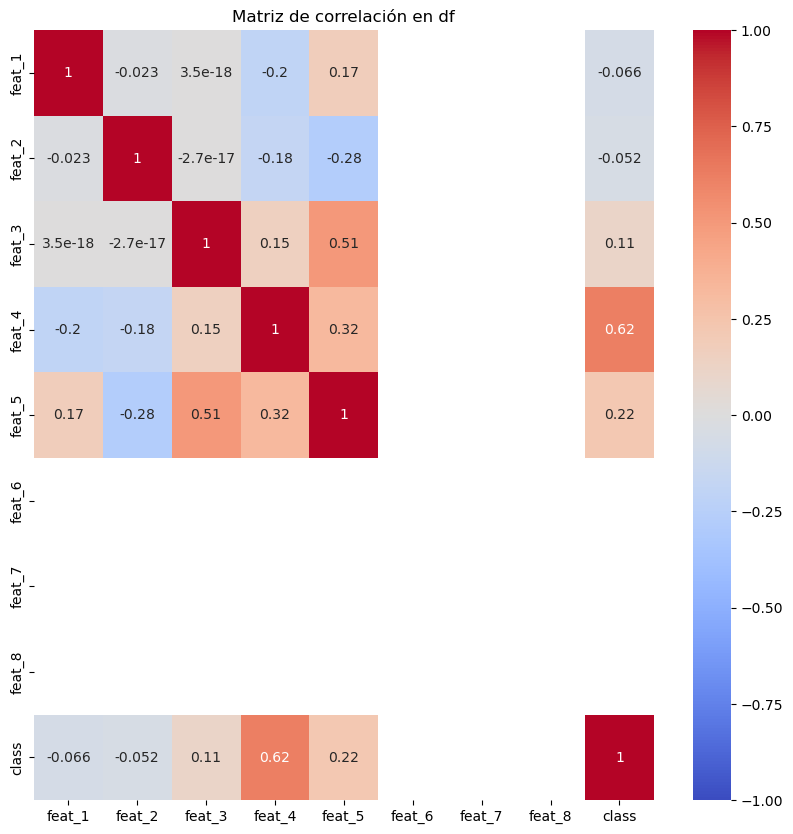

In [13]:
corr_matrix = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm',
            vmin=-1,
            vmax=1)
plt.title("Matriz de correlación en df")
plt.show()
# Hay que quitarle las características 6, 7 y 8 porque son constantes.

In [14]:
col_const = [f'feat_{i}' for i in range(6, 9)]
df.drop(columns = col_const, inplace = True)
df.head()


,feat_1,feat_2,feat_3,feat_4,feat_5,class
1995,0.004380,4,0.234043,0.077789,0.256918,1
120,0.000221,7,0.553191,0.047256,0.263612,0
2078,0.004557,1,0.765957,0.152516,0.685808,1
1782,0.000664,3,0.936170,0.128498,0.487057,1
749,0.004292,2,0.170213,0.043353,0.162005,0


## Normalización de las características numericas


In [15]:
# Estandarizar para que no afecte a los algoritmos basados en distancias como el SVM o los KNN
scaler = MinMaxScaler()

numericos = [col for col in df.columns if col != 'class']

df_numericos_scaled = scaler.fit_transform(df[numericos])
df_numericos_scaled = pd.DataFrame(df_numericos_scaled, columns = numericos)
df_numericos_scaled.head()

,feat_1,feat_2,feat_3,feat_4,feat_5
0,0.830492,0.500000,0.234043,0.143371,0.259799
1,0.033902,1.000000,0.553191,0.025308,0.268320
2,0.864394,0.000000,0.765957,0.432321,0.805719
3,0.118751,0.333333,0.936170,0.339449,0.552735
4,0.813637,0.166667,0.170213,0.010216,0.138988


## Unir los numericos normalizados con la clase en un df final

In [16]:
df_final = pd.concat([df_numericos_scaled.reset_index(drop = True), 
                      df['class'].reset_index(drop = True)], axis = 1)
df_final.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,class
0,0.830492,0.500000,0.234043,0.143371,0.259799,1
1,0.033902,1.000000,0.553191,0.025308,0.268320,0
2,0.864394,0.000000,0.765957,0.432321,0.805719,1
3,0.118751,0.333333,0.936170,0.339449,0.552735,1
4,0.813637,0.166667,0.170213,0.010216,0.138988,0


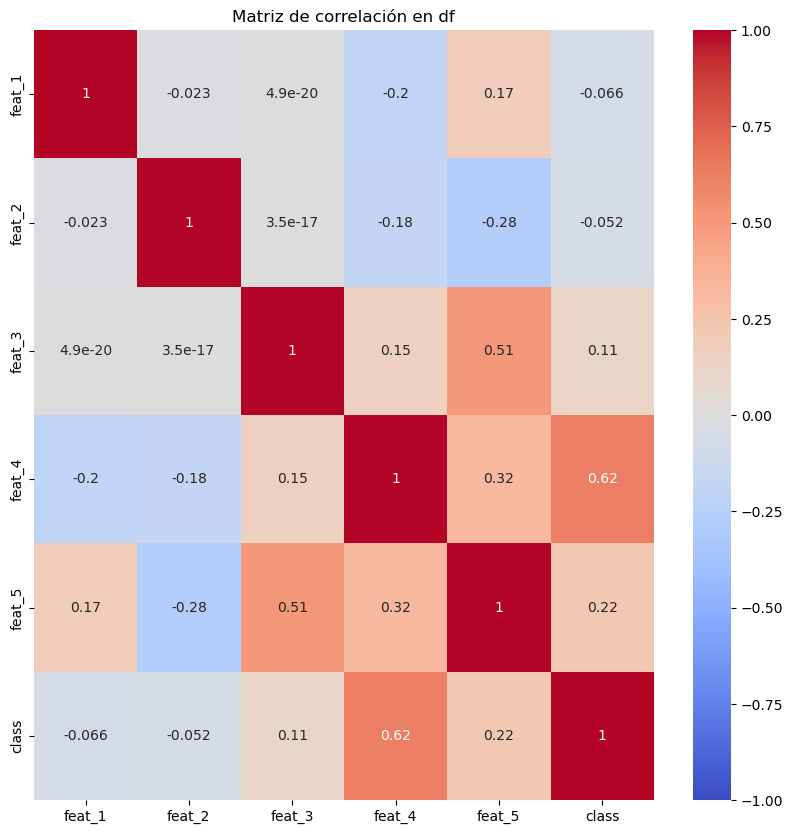

In [17]:
corr_matrix = df_final.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm',
            vmin=-1,
            vmax=1)
plt.title("Matriz de correlación en df")
plt.show()

## Guardar Dataset FInal

In [18]:
df_final.to_csv('../data/Electricity_limpio.csv', index = False)